In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12
import emcee
import scipy.stats
import corner
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [2]:
data= np.load('transient.npy')

First, always start with a quick look at the data

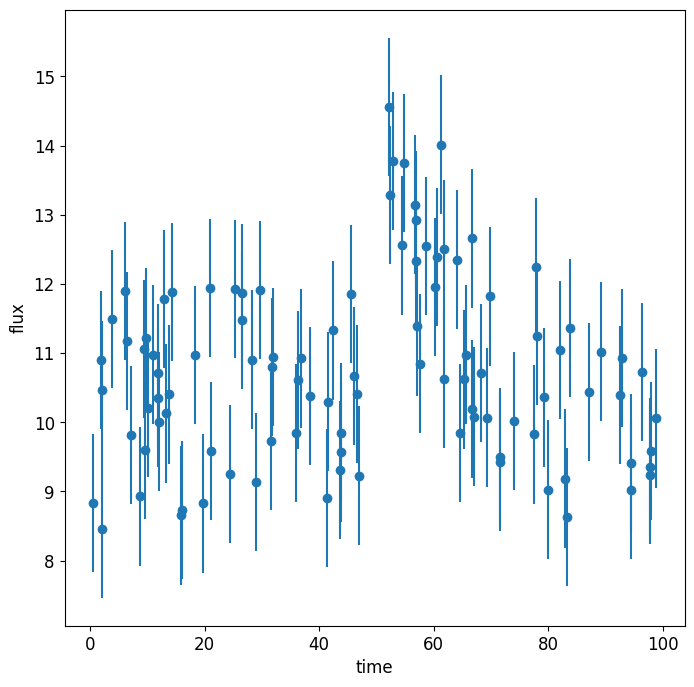

In [3]:
t,y,yerr=data.T
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux");

These are the old burst model and the new gaussian profile model:

In [4]:
def burst(theta,t):
    A,b,t0,alpha=theta 
    return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))


def gprofile(theta,t):
    A,b,t0,sigmaW=theta     
    return b+A*np.exp(-(((t-t0)/sigmaW)**2 ) / 2)


t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
sigmaWmin,sigmaWmax=np.exp(-2),np.exp(2)



First, let's reproduce our previous results using dinesty

In [5]:
# Define the dimensionality of our problem.
ndim = 4

def loglike(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst':
        y_fit = burst(theta, x)
    elif model == 'gprofile':
        y_fit = gprofile(theta, x)

    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 


def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
   
    if model =='burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'burst'],ptform_args=['burst'],nlive=300)
sampler.run_nested()
sresults = sampler.results

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1100it [00:08, 34.74it/s, bound: 0 | nc: 19 | ncall: 10975 | eff(%): 10.023 | loglstar:   -inf < -171.440 <    inf | logz: -179.890 +/-  0.159 | dlogz: 108.586 >  0.309]    /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1122it [00:08, 65.29it/s, bound: 1 | nc: 5 | ncall: 11077 | eff(%): 10.129 | loglstar:   -inf < -163.782 <    inf | logz: -172.424 +/-  0.158 | dlogz: 101.179 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered 

1660it [00:14, 26.45it/s, bound: 14 | nc: 103 | ncall: 17203 | eff(%):  9.649 | loglstar:   -inf < -89.866 <    inf | logz: -97.169 +/-  0.147 | dlogz: 39.349 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1683it [00:15, 42.65it/s, bound: 15 | nc: 33 | ncall: 17632 | eff(%):  9.545 | loglstar:   -inf < -89.456 <    inf | logz: -96.757 +/-  0.146 | dlogz: 38.859 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1689it [00:15, 40.37it/s, bound: 16 | nc: 78 | ncall: 17795 | eff(%):  9.491 | loglstar:   -inf < -89.373 <    inf | logz: -9

1785it [00:20, 11.46it/s, bound: 29 | nc: 144 | ncall: 23621 | eff(%):  7.557 | loglstar:   -inf < -88.264 <    inf | logz: -95.335 +/-  0.144 | dlogz: 37.089 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1789it [00:20, 13.99it/s, bound: 29 | nc: 99 | ncall: 23827 | eff(%):  7.508 | loglstar:   -inf < -88.235 <    inf | logz: -95.294 +/-  0.144 | dlogz: 37.035 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1791it [00:21,  9.39it/s, bound: 30 | nc: 86 | ncall: 24383 | eff(%):  7.345 | loglstar:   -inf < -88.217 <    inf | log

1904it [00:26, 23.19it/s, bound: 43 | nc: 25 | ncall: 30179 | eff(%):  6.309 | loglstar:   -inf < -87.546 <    inf | logz: -94.409 +/-  0.142 | dlogz: 35.763 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1913it [00:27, 21.76it/s, bound: 44 | nc: 174 | ncall: 30706 | eff(%):  6.230 | loglstar:   -inf < -87.531 <    inf | logz: -94.360 +/-  0.142 | dlogz: 35.683 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
1917it [00:27, 23.38it/s, bound: 45 | nc: 49 | ncall: 30834 | eff(%):  6.217 | loglstar:   -inf < -87.515 <    inf | logz: -94

2015it [00:32, 16.59it/s, bound: 57 | nc: 200 | ncall: 36615 | eff(%):  5.503 | loglstar:   -inf < -87.261 <    inf | logz: -93.928 +/-  0.141 | dlogz: 34.911 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2019it [00:32, 13.37it/s, bound: 58 | nc: 114 | ncall: 37040 | eff(%):  5.451 | loglstar:   -inf < -87.256 <    inf | logz: -93.916 +/-  0.141 | dlogz: 34.885 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in mul

2065it [00:38, 11.74it/s, bound: 72 | nc: 92 | ncall: 43382 | eff(%):  4.760 | loglstar:   -inf < -87.174 <    inf | logz: -93.784 +/-  0.140 | dlogz: 35.719 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2067it [00:38,  9.85it/s, bound: 73 | nc: 172 | ncall: 43703 | eff(%):  4.730 | loglstar:   -inf < -87.172 <    inf | logz: -93.779 +/-  0.140 | dlogz: 35.707 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in mult

2108it [00:44,  9.49it/s, bound: 87 | nc: 55 | ncall: 49898 | eff(%):  4.225 | loglstar:   -inf < -87.133 <    inf | logz: -93.685 +/-  0.140 | dlogz: 35.476 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2110it [00:44,  8.62it/s, bound: 88 | nc: 204 | ncall: 50206 | eff(%):  4.203 | loglstar:   -inf < -87.131 <    inf | logz: -93.681 +/-  0.140 | dlogz: 35.465 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2115it [00:45, 12.75it/s, bound: 88 | nc: 37 | ncall: 50532 | eff(%):  4.185 | loglstar:   -inf < -87.129 <    inf | logz: -93.670 +/-  0.140 | dlogz: 35.438 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return n

2210it [00:50, 17.68it/s, bound: 101 | nc: 46 | ncall: 56275 | eff(%):  3.927 | loglstar:   -inf < -87.091 <    inf | logz: -93.515 +/-  0.139 | dlogz: 34.966 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2212it [00:50, 13.82it/s, bound: 102 | nc: 160 | ncall: 56580 | eff(%):  3.910 | loglstar:   -inf < -87.091 <    inf | logz: -93.512 +/-  0.139 | dlogz: 34.956 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2214it [00:50, 12.84it/s, bound: 102 | nc: 132 | ncall: 56820 | eff(%):  3.897 | loglstar:   -inf < -87.091 <    inf | logz: -93.510 +/-  0.139 | dlogz: 34.947 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  retur

2285it [00:56, 10.25it/s, bound: 116 | nc: 243 | ncall: 63057 | eff(%):  3.624 | loglstar:   -inf < -86.871 <    inf | logz: -93.428 +/-  0.139 | dlogz: 34.629 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2287it [00:56, 10.26it/s, bound: 117 | nc: 31 | ncall: 63261 | eff(%):  3.615 | loglstar:   -inf < -86.859 <    inf | logz: -93.425 +/-  0.139 | dlogz: 34.620 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2294it [00:56, 15.68it/s, bound: 117 | nc: 47 | ncall: 63664 | eff(%):  3.603 | loglstar:   -inf < -86.789 <    inf | logz: -93.417 +/-  0.139 | dlogz: 34.588 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  retur

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2322it [01:03,  1.94it/s, bound: 135 | nc: 819 | ncall: 71617 | eff(%):  3.242 | loglstar:   -inf < -86.442 <    inf | logz: -93.379 +/-  0.139 | dlogz: 34.457 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2323it [01:04,  2.13it/s, bound: 136 | nc: 247 | ncall: 71864 | eff(%):  3.232 | loglstar:   -inf < -86.438 <    inf | logz: -93.378 +/-  0.139 | dlogz: 34.453 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in m

2418it [01:09, 15.40it/s, bound: 149 | nc: 142 | ncall: 77709 | eff(%):  3.112 | loglstar:   -inf < -84.019 <    inf | logz: -92.967 +/-  0.145 | dlogz: 34.624 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
2424it [01:09, 14.22it/s, bound: 150 | nc: 14 | ncall: 78339 | eff(%):  3.094 | loglstar:   -inf < -83.979 <    inf | logz: -92.919 +/-  0.146 | dlogz: 34.555 >  0.309] /var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in m

2622it [01:16, 62.78it/s, bound: 166 | nc: 14 | ncall: 85276 | eff(%):  3.075 | loglstar:   -inf < -77.726 <    inf | logz: -88.620 +/-  0.180 | dlogz: 30.606 >  0.309]/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_67238/2122527065.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0,b,b+A*np.exp(-alpha*(t-t0)))
4648it [01:31, 50.81it/s, +300 | bound: 201 | nc: 1 | ncall: 101575 | eff(%):  4.886 | loglstar:   -inf < -48.759 <    inf | logz: -62.983 +/-  0.210 | dlogz:  0.001 >  0.309]


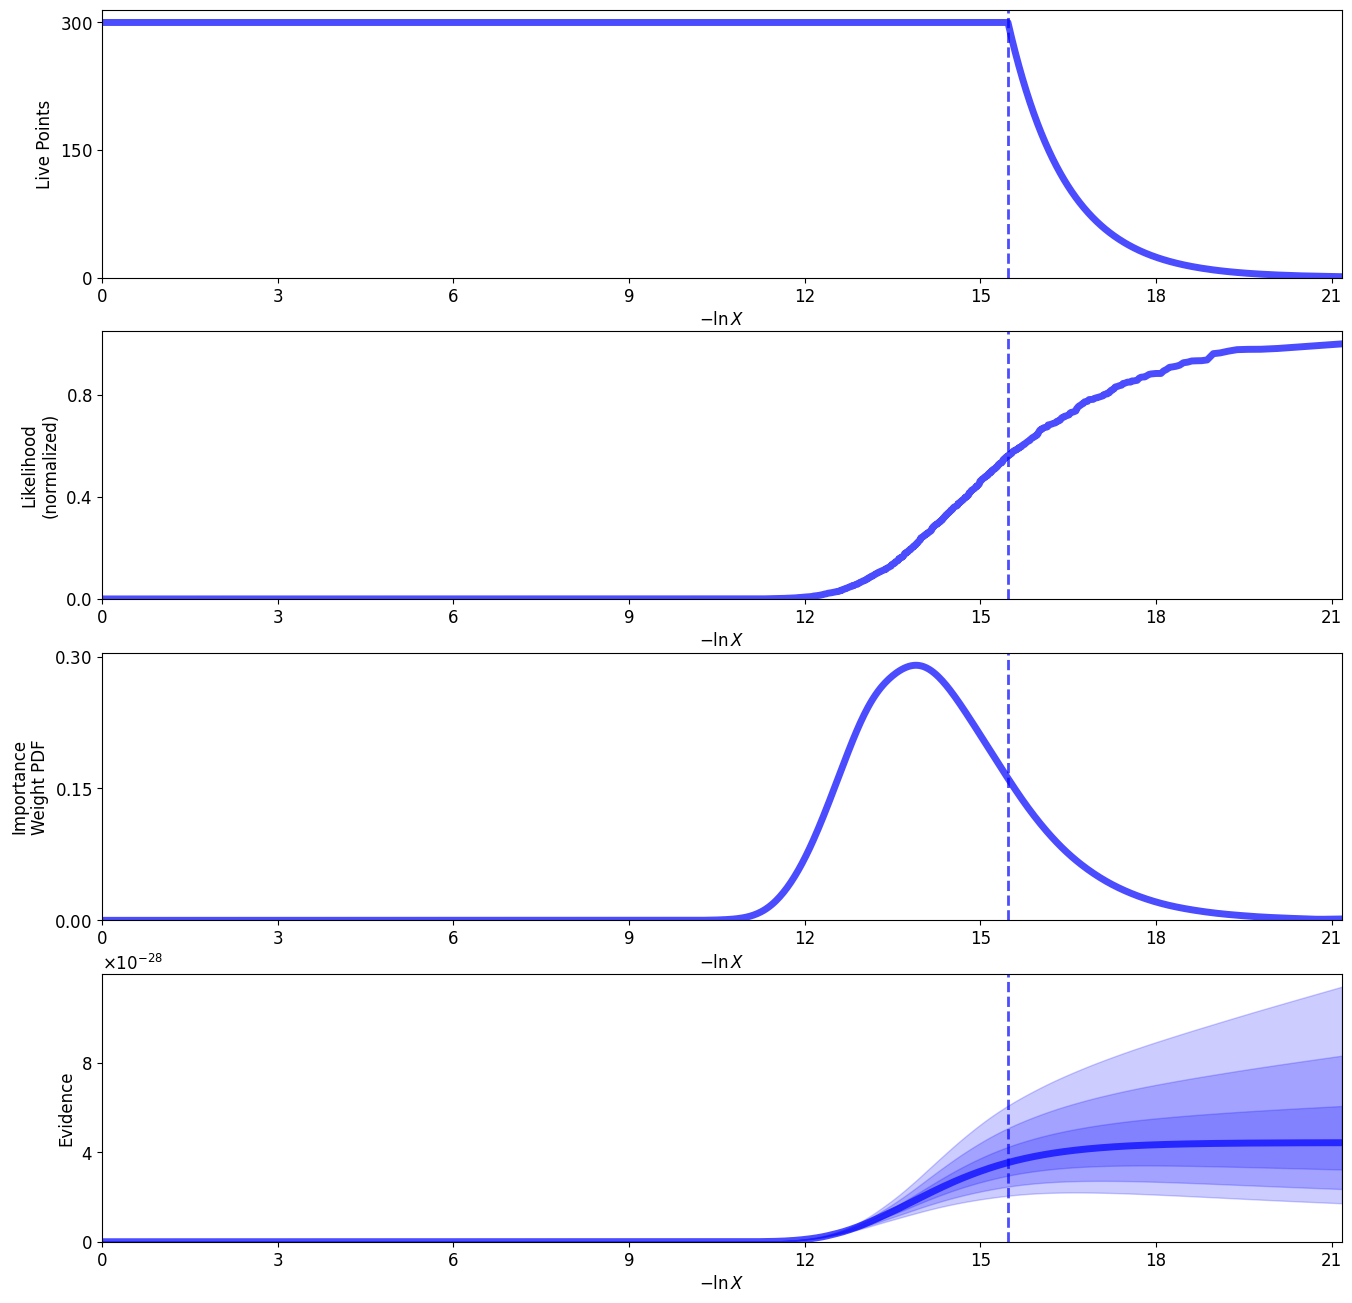

In [7]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

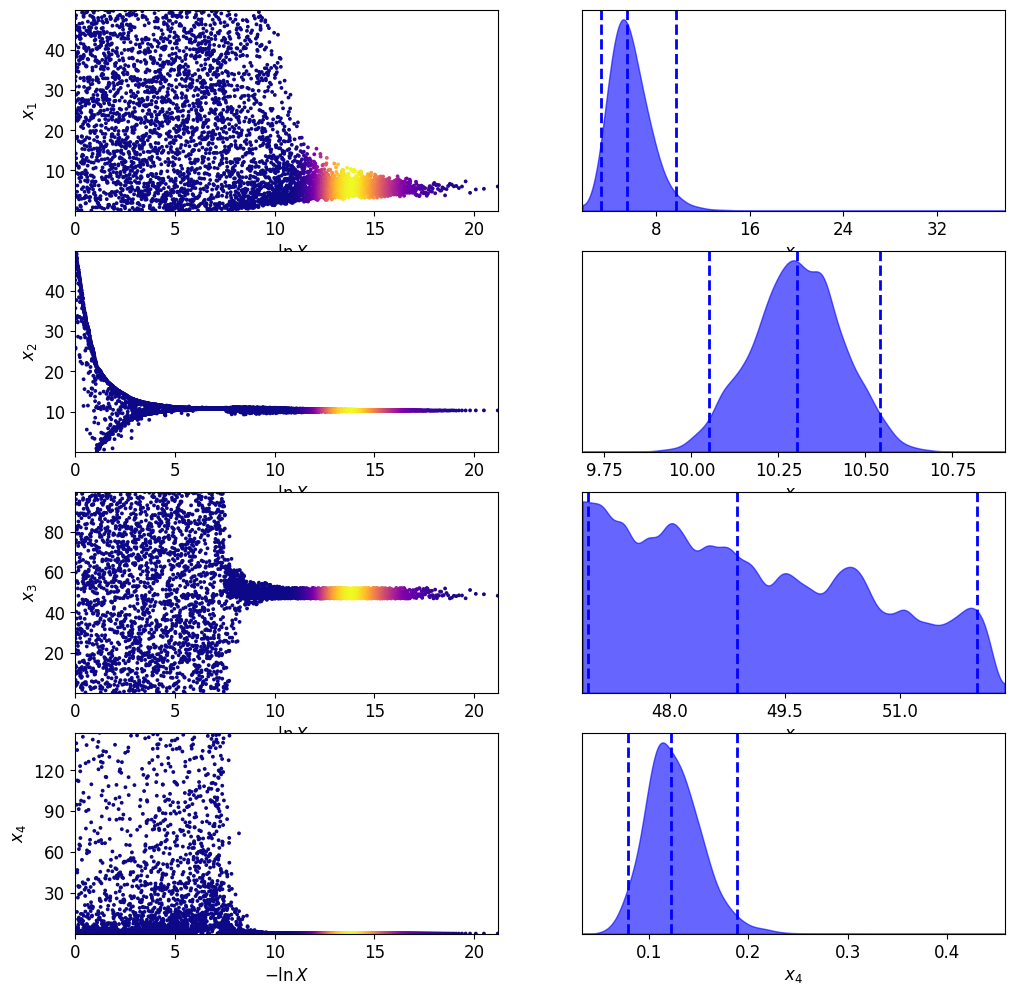

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

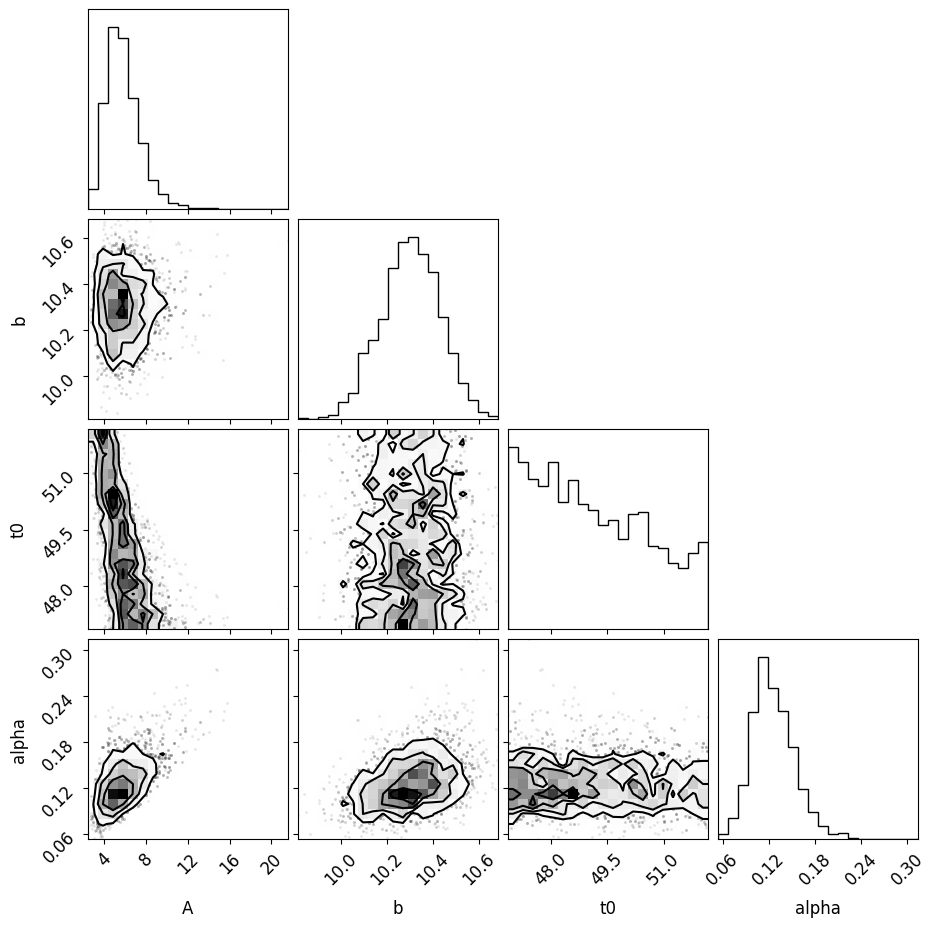

In [9]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["A","b","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [10]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,labels):
    low,med,up=q
    print(l+"   "+str(med)+" +"+str(up-med)+" -"+str(med-low))



A   5.55126217695793 +3.2551387271078847 -1.9384056079636593
b   10.303406118067114 +0.20315491600308633 -0.21613216032927163
t0   48.87354219358687 +2.958144429077585 -1.83445034541446
alpha   0.12273771311543019 +0.05285801160633666 -0.03856796990899197


In [11]:
sresults.summary()

Summary
nlive: 300
niter: 4648
ncall: 101275
eff(%):  4.886
logz: -62.983 +/-  0.315


Ok now let's move on with the Gaussian profile:

In [12]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'gprofile'],ptform_args=['gprofile'],nlive=300)
sampler.run_nested()
sresults2 = sampler.results


4992it [01:35, 52.18it/s, +300 | bound: 204 | nc: 1 | ncall: 102810 | eff(%):  5.162 | loglstar:   -inf < -52.464 <    inf | logz: -67.853 +/-  0.220 | dlogz:  0.001 >  0.309]


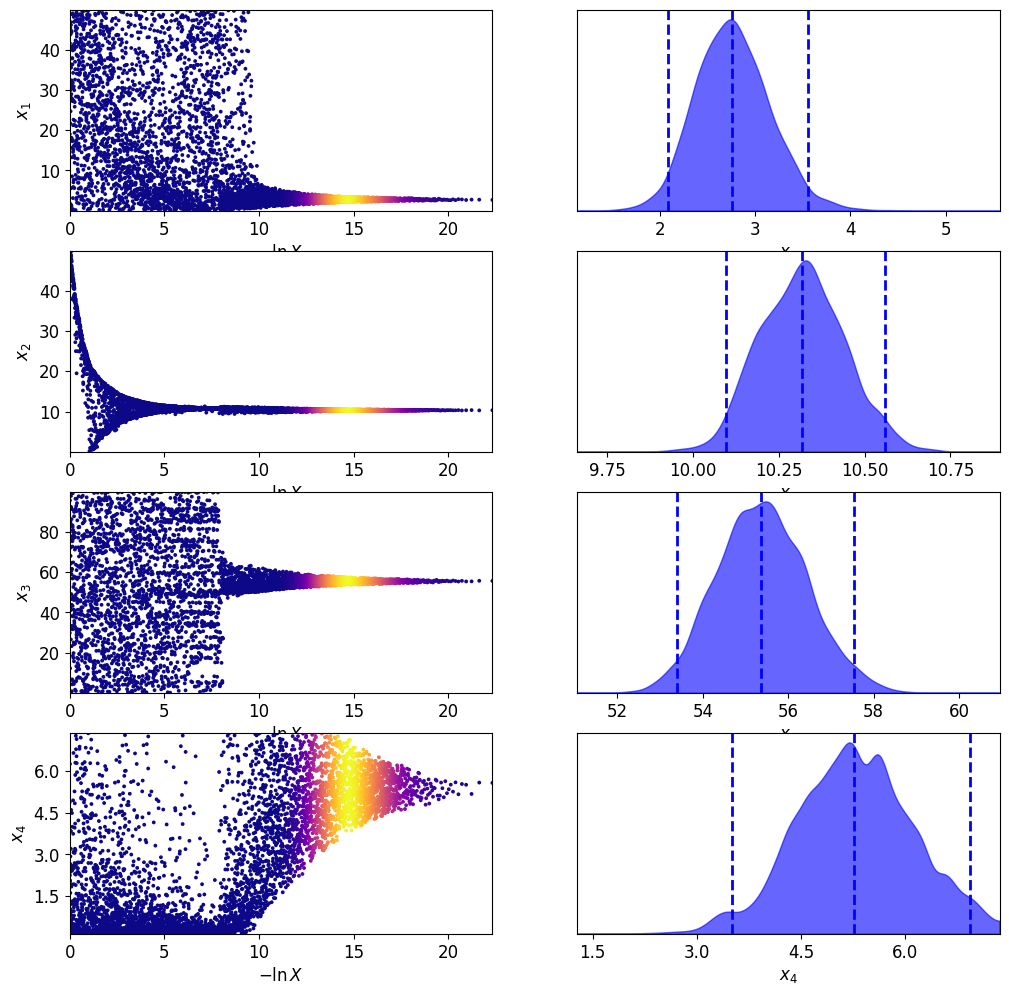

In [13]:
tfig, taxes = dyplot.traceplot(sresults2)

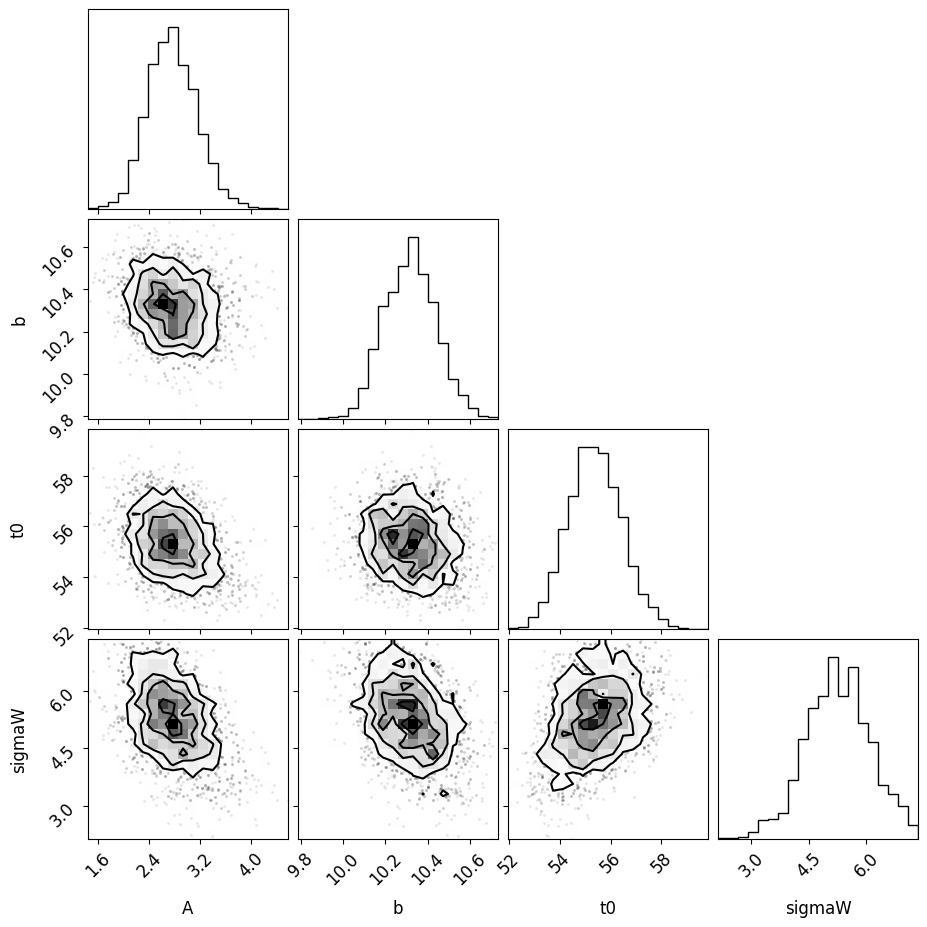

In [14]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

labels = ["A","b","t0","sigmaW"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);

In [15]:
sresults2.summary()

Summary
nlive: 300
niter: 4992
ncall: 102510
eff(%):  5.162
logz: -67.853 +/-  0.325


Now compute the odds ratio (assuming equal hyperpriors) between the two models:

In [16]:
np.exp(sresults.logz[-1])/np.exp(sresults2.logz[-1])

130.2354183361008

This is "very strong" evidence in favour of the burst model

Something I haven't done (but you should): 
- check if this number is robust with respect to the nested sampling hyperparameters (number of live points, dlogz threshold where the fit is terminated)
- Assign an error to this estimate of the Bayes factor.

Let's plot some models

Text(0, 0.5, 'flux')

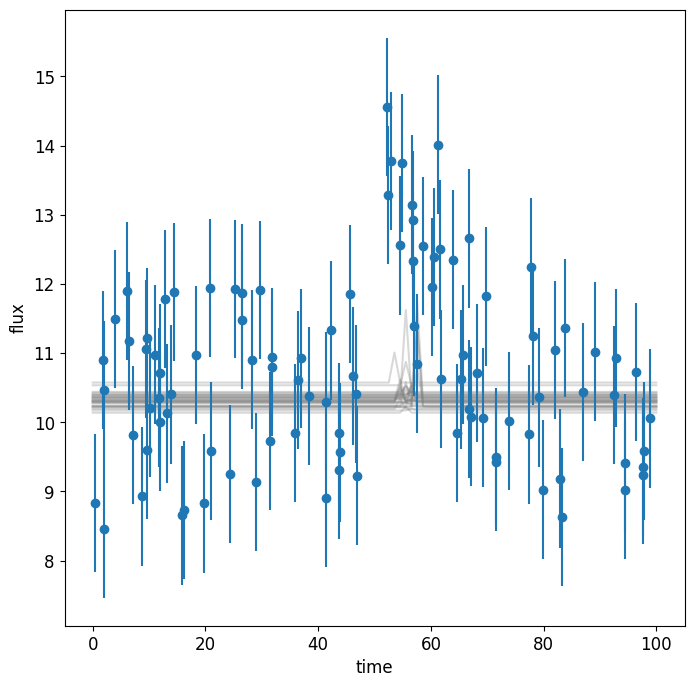

In [17]:
tgrid=np.linspace(0,100,100)

chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=30)]

for chosen_theta in chosen_samples:

    ygrid =  burst(chosen_theta,tgrid)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")

Indeed, look how badly this is describing the data... Let's try to understand why (play a bit with the fit by hand...)

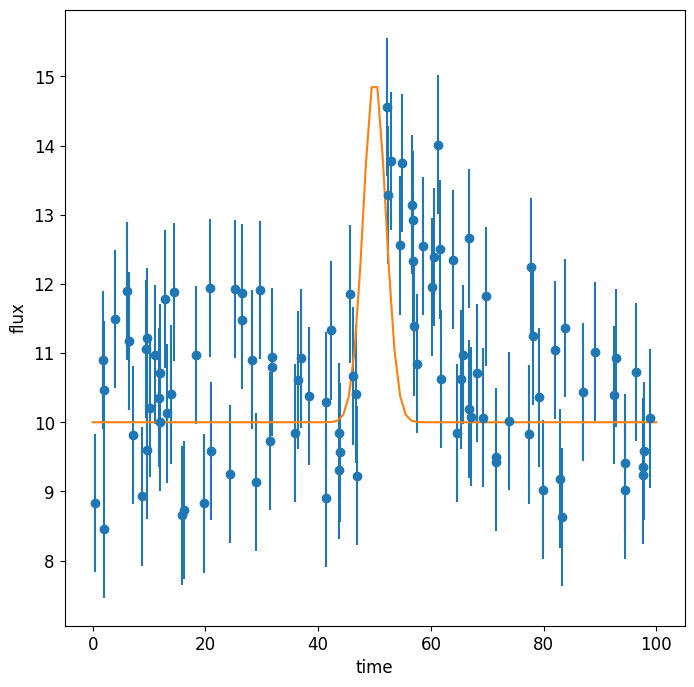

In [18]:
tgrid=np.linspace(0,100,100)
t0_quick=50
A_quick=5
b_quick=10
sigmaW_quick=2


theta_quick= np.array([A_quick,b_quick,t0_quick,sigmaW_quick])
ygrid =  gprofile(theta_quick,tgrid)

plt.errorbar(t,y,yerr=yerr,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.plot(tgrid,ygrid)

Remember this does not tell you that a model is correct, only that one is better than the other.